In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


часть 1 - удаляем все нулевое и категориальное, учим

In [3]:
df_cut = data.select_dtypes(exclude=['object'])
df_cut = df_cut.dropna()
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        714 non-null    int64  
 5   Parch        714 non-null    int64  
 6   Fare         714 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 44.6 KB


In [4]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
features_columns = [c for c in df_cut.columns if c != 'Survived']
X = df_cut[features_columns]
y = df_cut['Survived']

model = LogisticRegression(max_iter=1e4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)

Строим метрику - выбрал площадь под кривой ROC как одну из часто используемых для бинарной классификации. 

Небаланс классов (для задач с которым эта метрика используется чаще других) тут небольшой (около 4/10), можно было и другую выбрать.

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

sk_fpr, sk_tpr, thres = roc_curve( y_test, predictions[:, 1])
from matplotlib import pyplot as plt
# plt.plot( sk_fpr, sk_tpr )
roc_auc_score(y_test, predictions[:, 1])

0.728099173553719

все по-новой, теперь с умом

In [6]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Удаляем лишние признаки: 
* PassengerId (просто индекс)
* Ticket (номер билета - скорее всего как-то сложно коррелирует с классом и Cabin, и все)
* Embarked (пункт назначения) тоже вряд ли влияет, но можно оставить

In [7]:
df = data.drop(['PassengerId','Ticket'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


Заполним пропуски (тольк в трех колонках)
* Age - статистически - выберем среднее, как наиболее вероятное значение
* Cabin и Embarked - сложно угадать, поэтому добавим столбцы с пометками о пропущенном значении (это произойдет при one hot encoding)

In [8]:
df['NoCabin'] = 0
df['NoCabin'] = df['NoCabin'].mask(df['Cabin'].isna(),other=1)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,NoCabin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S,1
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B42,S,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,NaN,S,1
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C148,C,0


In [9]:

df['Age'] = df['Age'].fillna(-1) # не 0, т.к. Age может быть = 0


In [10]:
df['NoCabin'] = 0
df['NoCabin'] = df['NoCabin'].mask(df['Cabin'].isna(),other=1)
df['Cabin'] = df['Cabin'].fillna('unset')


In [11]:
df['NoEmbarked'] = 0
df['NoEmbarked'] = df['NoEmbarked'].mask(df['Embarked'].isna(),other=1)
df['Embarked'] = df['Embarked'].fillna('unset')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         891 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Fare        891 non-null    float64
 8   Cabin       891 non-null    object 
 9   Embarked    891 non-null    object 
 10  NoCabin     891 non-null    int64  
 11  NoEmbarked  891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


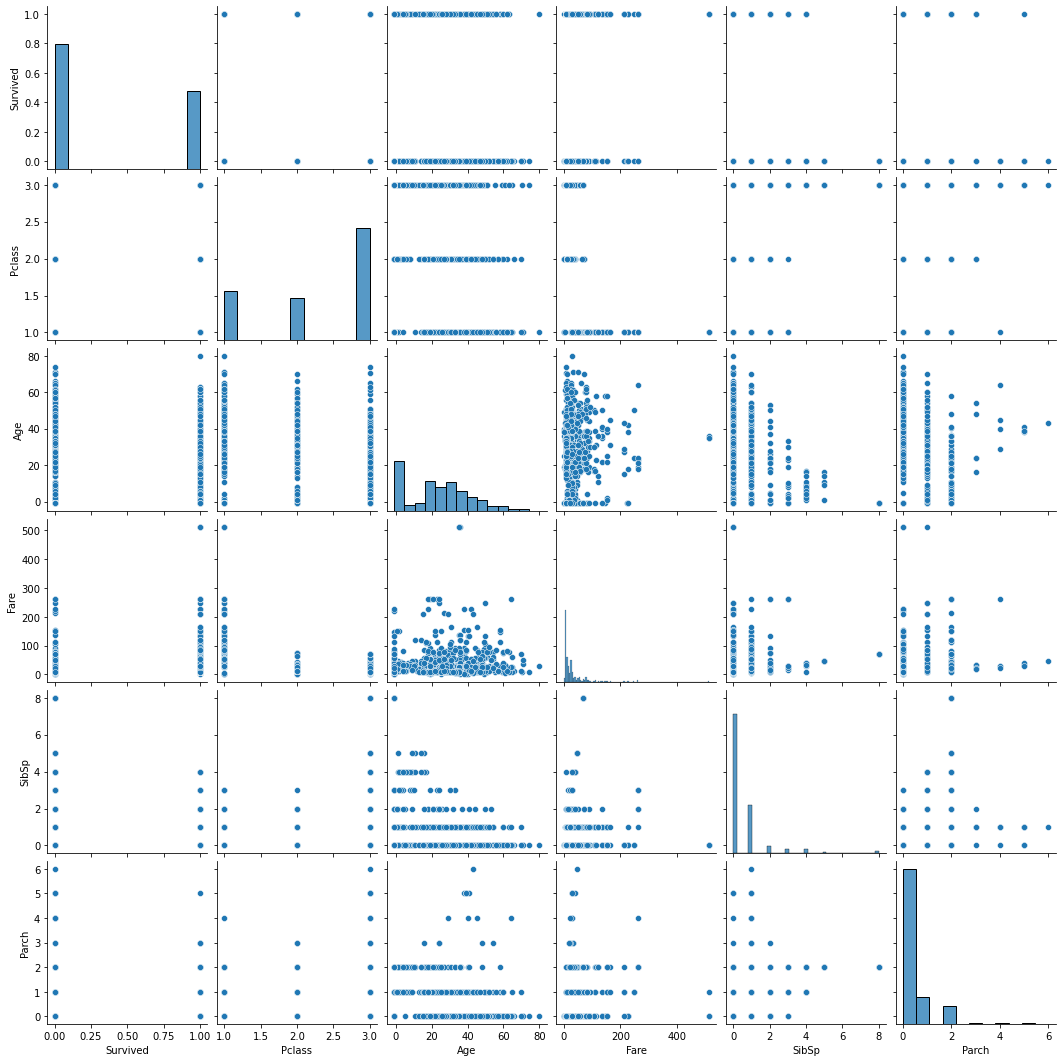

In [12]:
import seaborn as sns
sns.pairplot(df[['Survived','Pclass','Age','Fare','SibSp','Parch']])

Заметны выбросы в колонках:
* Fare
* может быть, но сомнительно - 'SibSp','Parch'

<AxesSubplot:xlabel='Parch'>

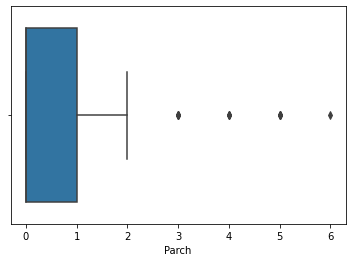

In [16]:
sns.boxplot(x=X['Parch'])

Все три колонки проверил, с т.з. здравого смысла, проблем не вижу - все значения реально возможны.

Выбросы не удаляю.

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df = df.apply(le.fit_transform)
X = df[[c for c in df.columns if c != 'Survived']]
y = df['Survived']

In [13]:
model = LogisticRegression(max_iter=1e4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

sk_fpr, sk_tpr, thres = roc_curve( y_test, predictions[:, 1])
from matplotlib import pyplot as plt
# plt.plot( sk_fpr, sk_tpr )
roc_auc_score(y_test, predictions[:, 1])

0.8448844884488449

**Значения roc_auc_score**

* просто без удаления строк было - 0.728
* с обработкой категориальных признаков и заполнением пустых значений - 0.845 


Выводы: обработка данных существенно улучшила метрику. Обработка - необходимая процедура на данных, которые можно вручную преобразовать (небольшой размерности, с понятными человеку смыслами признаков).

Для большой размерности обработка таким образом не целесообразна, необходимо придумывать методы автоматической обработки данных.

Эти методы необходимо тестировать. Желательно в методы обработки данных добавлять гиперпараметры (понятные человеку) и уже их обучать.
Т.е. обработка данных перед ML сама должна быть процессом с использованием машинного обучения (для ускорения работы).